The important features:
 ['latitude', 'longitude', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'milestones', 'avg_participants', 'is_top500', 'founded_at_Year', 'founded_at_Month', 'first_funding_at_Month', 'last_funding_at_Month']
The 1 predicting
The prediction is:
[0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1] 
The best accuracy of Adaboost prediction is 0.8266666666666667
_____________________
The 2 predicting
The prediction is:
[0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1] 
The best accuracy of Adaboost prediction is 0.8266666666666667
_____________________
The 3 predicting
The prediction is:
[0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1
 0 1 1 1

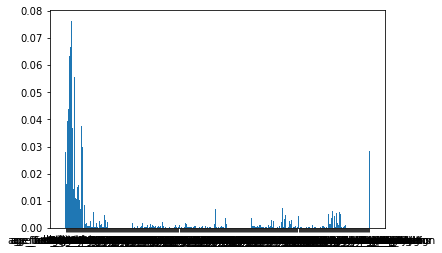

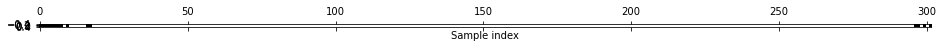

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
import xlwt

# DataFrame setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data cleaning
def DataReprocessing(DataPath):
    traindata = pd.read_excel(DataPath)
    df = pd.DataFrame(traindata)
    df.rename(columns={"Unnamed: 0" : "Unknow"},inplace=True)
    df.rename(columns={"Unnamed: 6" : "address"}, inplace=True)
    # Delete the address because it can be composited by zip_code, state_code and city
    del df["address"]
    # Delete the is_CA, is_NY, is_MA, is_TX and is_otherstate
    del df["is_CA"]
    del df["is_NY"]
    del df["is_MA"]
    del df["is_TX"]
    del df["is_otherstate"]
    # Delete the is_software, is_web, is_mobile, is_enterprise, is_advertising, is_gamesvideo, is_ecommerce, is_biotech, is_consulting, is_othercategory
    del df["is_software"]
    del df["is_web"]
    del df["is_mobile"]
    del df["is_enterprise"]
    del df["is_advertising"]
    del df["is_gamesvideo"]
    del df["is_ecommerce"]
    del df["is_biotech"]
    del df["is_consulting"]
    del df["is_othercategory"]
    # Delete object_id and state_code.1 because of repeat
    del df["object_id"]
    del df["state_code.1"]
    del df["name"]
    del df["id"]
    del df["zip_code"]
    del df["Unknow"]
    if "labels" in df.columns:
        del df["labels"]
    if "ID" in df.columns:
        del df["ID"]
    # Data missing
    df.fillna(value=0)
    # Transform object into DateTime
    df["founded_at"] = pd.to_datetime(df["founded_at"])
    df["first_funding_at"] = pd.to_datetime(df["first_funding_at"])
    df["last_funding_at"] = pd.to_datetime(df["last_funding_at"])
    # Transform object into int
    df["status"] = df["status"].replace('acquired', 1)
    df["status"] = df["status"].replace('closed',0)
    return df

# Feature engineering -- return DataFrame
def DataProcessing(Data):
    y = Data["status"]
    data = Data
    # print(data.dtypes)
    # Processing category data: state_code, city, category_code
    data = pd.get_dummies(data)
    # print(data.shape)
    # processing numerical data: latitude, longitude, age_first_funding_year, age_last_funding_year, age_first_milestone_year, age_last_milestone_year, relationships, funding_rounds, funding_total_usd, milestones and avg_participants
    data["latitude"] = ProcessingNumericalData(data["latitude"])
    data["longitude"] = ProcessingNumericalData(data["longitude"])
    data["age_first_funding_year"] = ProcessingNumericalData(data["age_first_funding_year"])
    data["age_last_funding_year"] = ProcessingNumericalData(data["age_last_funding_year"])
    data["age_first_milestone_year"] = ProcessingNumericalData(data["age_first_milestone_year"])
    data["age_last_milestone_year"] = ProcessingNumericalData(data["age_last_milestone_year"])
    data["relationships"] = ProcessingNumericalData(data["relationships"])
    data["funding_rounds"] = ProcessingNumericalData(data["funding_rounds"])
    data["funding_total_usd"] = ProcessingNumericalData(data["funding_total_usd"])
    data["milestones"] = ProcessingNumericalData(data["milestones"])
    data["avg_participants"] = ProcessingNumericalData(data["avg_participants"])

    # processing temporal data
    # Extract Year and Month from DateFrame
    data["founded_at_Year"] = data["founded_at"].dt.year
    data["founded_at_Month"] = data["founded_at"].dt.month


    data["first_funding_at_Year"] = data["first_funding_at"].dt.year
    data["first_funding_at_Month"] = data["first_funding_at"].dt.month

    data["last_funding_at_Year"] = data["last_funding_at"].dt.year
    data["last_funding_at_Month"] = data["last_funding_at"].dt.month

    # Time binning -- Year  11 represents NaN
    year_bins = [1980,1985,1990,1995,2000,2005,2010,2015,2020,2025]
    year_bin_1 = np.digitize(data["founded_at_Year"], bins=year_bins)
    year_bin_3 = np.digitize(data["first_funding_at_Year"],bins=year_bins)
    year_bin_4 = np.digitize(data["last_funding_at_Year"],bins=year_bins)
    # Time binning - Month  5 represents NaN
    month_bins = [1,4,7,10]
    month_bin_1 = np.digitize(data["founded_at_Month"], bins=month_bins)
    month_bin_3 = np.digitize(data["first_funding_at_Month"], bins=month_bins)
    month_bin_4 = np.digitize(data["last_funding_at_Month"], bins=month_bins)

    data["founded_at_Year"] = year_bin_1
    data["first_funding_at_Year"] = year_bin_3
    data["last_funding_at_Year"] = year_bin_4

    data["founded_at_Month"]=month_bin_1
    data["first_funding_at_Month"] = month_bin_3
    data["last_funding_at_Month"] = month_bin_4

    # Delete repeated attributions
    del data["founded_at"]
    del data["first_funding_at"]
    del data["last_funding_at"]
    del data["status"]
    # print(data.dtypes)
    x = data
    y = y
    json = {
        "x": x,
        "y": y
    }
    # print(x.head(10))
    return json

# Model-based feature selection
def FeatureSelection(Data):
    X_train = Data["x"]
    df_X = X_train
    X_train = np.array(X_train)
    y_train = Data["y"]
    df_y = y_train
    # the importance of each feature
    rf = RandomForestClassifier()
    rf.fit(X_train,y_train.ravel())
    y_train = np.array(y_train).reshape(-1,1)
    importance = rf.feature_importances_
    # print(importance)
    plt.bar(df_X.columns,importance)
    select = SelectFromModel(
        RandomForestClassifier(n_estimators=50,random_state=150),
        threshold="median",max_features=15)
    select.fit(X_train, y_train.ravel())
    mask = select.get_support()
    columns = df_X.columns[mask].values.tolist()
    # visualize the mask -- black is True, white is False
    plt.matshow(mask.reshape(1, -1), cmap='gray_r')
    plt.xlabel("Sample index")
    #plt.show()
    # print(X_train_Selected.shape)    # (848,153)
    # print(type(X_train_Selected))    # ndarray
    original_columns = df_X.columns.values.tolist()
    for i in original_columns:
        if i not in columns:
            del df_X[i]
        else:
            continue
    print("The important features:\n {}".format(columns))
    json = {
        "Samples": df_X,
        "Targets": df_y,
        "Selected Features": columns
    }
    return json

# Principal Component Analysis
def PCAnalysis(Dataset):
    try:
        X_train = Dataset["Samples"]
        y_train = Dataset["Targets"]
        y_train = y_train.values.reshape(-1, 1)
        pca = PCA(n_components=10)
        pca.fit(X_train)
        X_pca = pca.transform(X_train)
        scaler = MinMaxScaler()
        scaler.fit(X_pca)
        X_scaler = scaler.transform(X_pca)  # ndarray
        json = {
            "Pricipal_Component": X_scaler,
            "Targets": y_train
        }
        return json
    except:
        X_train = Dataset["Samples"]
        pca = PCA(n_components=10)
        pca.fit(X_train)
        X_pca = pca.transform(X_train)
        scaler = MinMaxScaler()
        scaler.fit(X_pca)
        X_scaler = scaler.transform(X_pca)  # ndarray
        json = {
            "Pricipal_Component": X_scaler,
        }
        # print(type(X_scaler),type(y_train))
        return json


def Adaboost(Dataset):
    # Training and Testing
    trainData = Dataset["TrainData"]
    Features = trainData["Pricipal_Component"]
    Targets = trainData["Targets"]
    train_feature = Features[:]
    train_target = Targets[:]
    test_feature = Features[700:]
    test_target = Targets[700:]
    # for i in range(0,10):
    #     for j in range (i+1,10):
    #         mglearn.discrete_scatter(train_feature[:, i], train_feature[:, j],train_target.reshape(1,-1)[0],labels=["closed","acquired"])
    #         plt.legend(loc="best")
    #         plt.gca().set_aspect("equal")
    #         plt.xlabel("First principal component")
    #         plt.ylabel("Second principal component")
            # plt.show()
    adaboost = AdaBoostClassifier()
    adaboost.fit(train_feature,train_target.ravel())
    predict = adaboost.predict(test_feature)
    # print("The accuracy of adaboost is:{}".format(metrics.accuracy_score(test_target,predict)))
    Adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,criterion="gini"),algorithm="SAMME",n_estimators=320,learning_rate=0.9)
    accuracy_ = 0
    f = xlwt.Workbook()
    sheet = f.add_sheet(u'sheet1', cell_overwrite_ok=True)
    sheet.write(0, 0, "ID")
    for i in range(1,76):
        sheet.write(i,0,i)
    for i in range(0,30):
        Adaboost.fit(train_feature,train_target.ravel())
        predict_ = Adaboost.predict(test_feature)
        # print("The accuracy of testing is:{}".format(metrics.accuracy_score(test_target, predict_)))
        # Predicting
        predictData = Dataset["PredictData"]
        predict_feature = predictData
        # the target from label
        predict_target = [0,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,0,1,1,1,1,1,1,0,1,0,1,1,0,0,1,1,1,
                          1,1,0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,
                          1,0,1,1,1,1,1,0,1]
        predict_target = np.array(predict_target).reshape(-1,1)
        prediction = Adaboost.predict(predict_feature)
        accuracy = metrics.accuracy_score(prediction, predict_target)
        sheet.write(0,i,"Prediction_Status_{}".format(i))
        for j in range(0, 75):
            if prediction[j] == 1:
                sheet.write(j+1, i + 1, "acquired")
            else:
                sheet.write(j+1, i + 1, "closed")
        sheet.write(77,i+1,"accuracy:{}".format(accuracy))
        if accuracy > accuracy_:
            accuracy_ = accuracy
        print("The {} predicting".format(i+1))
        print("The prediction is:\n{} ".format(prediction))
        print("The best accuracy of Adaboost prediction is {}\n_____________________".format(accuracy_))
        i+=1
    f.save("./Output/result.xls")
    return Adaboost


# Processing numerical data, and this def is called in DataProcessing(Data)
def ProcessingNumericalData(input):
    mean = input.mean()
    std = input.std()
    bins = [(mean-3*std),(mean-2.5*std),(mean-2*std),(mean-1.5*std),(mean-std),(mean-0.5*std),
            mean,
            (mean+0.5*std),(mean+std),(mean+1.5*std),(mean+2*std), (mean+2.5*std),(mean+3*std)
            ]
    category = np.digitize(input,bins=bins)
    return category

def Dataset(TrainPath,PredictPath):
    trainData = DataReprocessing(TrainPath)
    train_data = DataProcessing(trainData)
    X_train = FeatureSelection(train_data)
    selected_feature = X_train["Selected Features"]
    DataSet = PCAnalysis(X_train)
    Predict_data = Predicting_Data(PredictPath,selected_feature)
    json = {
        "TrainData":DataSet,
        "PredictData":Predict_data
    }
    return json

def Predicting_Data(Path,columns):
    predicttData = DataReprocessing(Path)
    predict_data = DataProcessing(predicttData)["x"]
    original_columns = predict_data.columns.values.tolist()
    for i in original_columns:
        if i not in columns:
            del predict_data[i]
        else:
            continue
    Data = {
        "Samples": predict_data,
        "Targets": None,
        "Selected Features": None
    }
    # print(predict_data)
    predict_features = PCAnalysis(Data)["Pricipal_Component"]
    return predict_features

if __name__ == '__main__':
    # "./Data/startup_train.xlsx"
    # "./Data/startup_test.xlsx"
    dataset = Dataset("./Data/startup_train.xlsx","./Data/startup_test.xlsx")
    Adaboost(dataset)

